In [44]:
using NCDatasets
using DIVAnd
using PyPlot
using Dates
using Statistics
using Glob
using Test
const plt = PyPlot
include("./config.jl");
include("./ME4OH.jl")
doplot = false

[ Info: File already downloaded


false

## Create list of netCDF files
The files with the "nonan" extension were moved to another directory.

In [6]:
datafilelist = ME4OH.get_filelist(datadir, timeperiod1)

2-element Vector{String}:
 "/home/ctroupin/data/ME4OH/data/" ⋯ 55 bytes ⋯ "f.profiles.g10.197901.update.nc"
 "/home/ctroupin/data/ME4OH/data/" ⋯ 55 bytes ⋯ "f.profiles.g10.197902.update.nc"

## Experiment B
We perform purely 2D interpolations by looping on the monthly periods and the depth levels.     
The land-sea mask is created on the 3 specified depth levels.

In [9]:
depth_dohc = [depthlayer1[end], depthlayer2[end], depthlayer3[end]]

3-element Vector{Float64}:
  286.6
  685.9
 1985.3

In [10]:
xi, yi, mask_dohc = DIVAnd.load_mask(bathyfile, true, longrid, latgrid, depth_dohc);        
_, (pm, pn), (xi, yi) = DIVAnd_rectdom(longrid, latgrid);

### Prepare the time grid 
According to the time period specified in `config.jl`.

In [22]:
timegrid1 = get_timegrid(timeperiod1);

## Perform analysis
### Create the netCDF files that will store the results
The output directory is specified in `config.jl`.

In [114]:
outputfilelist = []
for depthlayer in [depthlayer1, depthlayer2, depthlayer3]
    fname = make_fname(timeperiod1, depthlayer, "A")
    outputfile = joinpath(outputdir, fname)
    isfile(outputfile) ? rm(outputfile) : @debug("OK")
    create_netcdf_results(outputfile, longrid, latgrid, timegrid1)
    
    # Add the residual variables in the netCDF
    add_residuals(outputfile, datafilelist)
    
    # Add file to the list
    push!(outputfilelist, outputfile)
end

### Loop on the files and the depths

In [115]:
for (ntime, datafile) in enumerate(datafilelist)
    
    # Read observations
    lon, lat, dates, depth, T, S, dohc = read_profile(datafile)
    
    # Modify coordinates
    lon[lon .< 20.] .+= 360
    
    # Loop on the 3 depth levels
    for ii = 1:1
        
        # Select good values (no NaNs)
        obsval = dohc[ii,:]
        goodval = findall(.!isnan.(obsval));
        ngood = length(goodval)
        
        # Perform interpolation
        fi, s = DIVAndrun(mask_dohc[:,:,ii], (pm, pn), (xi, yi), (Float64.(lon[goodval]), 
        Float64.(lat[goodval])), Float64.(obsval[goodval] .- mean(obsval[goodval])), 
        (5., 5.), 10.; moddim=[1,0])
        
        # Compute residuals
        dataresidual = DIVAnd_residual(s, fi)
        
        # Write field and residual in the netCDF
        NCDataset(outputfilelist[ii], "a") do ds
            ds["dohc"][:,:,ntime] = fi
            ds["obslon"][1:ngood,ntime] = lon[goodval]
            ds["obslat"][1:ngood,ntime] = lat[goodval]
            ds["obstime"][1:ngood,ntime] = dates[goodval]
            ds["dohc_residuals"][1:ngood,ntime] = dataresidual
        end
        
        # Make plot
        if doplot
            fig = plt.figure(figsize=(15, 8))
            ax = plt.subplot(121)
            ax.scatter(lon[goodval], lat[goodval], s=3, c=obsval[goodval])
            ax.set_xlim(20., 380.)
            ax = plt.subplot(122)
            ax.pcolormesh(longrid, latgrid, fi' .+ mean(obsval[goodval]))
            ax.set_xlim(20., 380.)
            plt.show()
        end
    end
end

## Temperature analysis

In [15]:
datafile = datafilelist[1]

"/home/ctroupin/data/ME4OH/data/en4.1.1/1979-2014/full/update/ofam3-jra55.all.EN.4.1.1.f.profiles.g10.197901.update.nc"

In [114]:
lon, lat, dates, depth, T, S, dohc = ME4OH.read_profile(datafile)
lon[lon .< 20.] .+= 360;
obslon, obslat, obsdates, obsdepth, T, S = ME4OH.vectorize_obs(lon, lat, dates, depth, T, S);

### Set grids
Lon and lat grid are defined in `config.jl`.     
The depth levels are the same as the profiles.

In [115]:
depthgrid = depth

51-element Vector{Float32}:
    2.5
    7.5
   12.5
   17.51539
   22.66702
   28.16938
   34.218006
   40.954975
   48.454975
   56.718006
   65.66938
   75.16702
   85.01539
    ⋮
 1115.3134
 1238.3539
 1368.1575
 1507.7339
 1658.1575
 1818.3539
 1985.3134
 2165.1802
 2431.101
 2894.8418
 3603.101
 4509.18

### Set the analysis parameters

In [116]:
sz = (length(longrid), length(latgrid), length(depthgrid))

lenx = fill(20.,sz)
leny = fill(20.,sz)
lenz = fill(0., sz);
len = (lenx, leny, lenz);
epsilon2 = 5.

5.0

### Run the analysis

In [106]:
_, pmn, xyi = DIVAnd_rectdom(longrid, latgrid, depthgrid);

In [107]:
xi, yi, mask = load_mask(bathyfile, true, longrid, latgrid, depthgrid);

In [117]:
@time Tinterp, s = DIVAndrun(mask, pmn, xyi, (obslon, obslat, obsdepth), Float64.(T .- mean(T)),
len, epsilon2, moddim=[1,0,0]);

 88.368411 seconds (4.33 M allocations: 34.733 GiB, 68.75% gc time)


In [143]:
?DIVAndrun

search: DIVAndrun DIVAndrunfi DIVAnd_residual DIVAnd_residualobs



```
DIVAndrun(mask,pmn,xi,x,f,len,epsilon2; <keyword arguments>)
```

Perform an n-dimensional variational analysis of the observations `f` located at the coordinates `x`. The array `fi` represent the interpolated field at the grid defined by the coordinates `xi` and the scales factors `pmn`.

# Input:

  * `mask`: binary mask delimiting the domain. true is inside and false outside.

For oceanographic application, this is the land-sea mask where sea is true and land is false.

  * `pmn`: scale factor of the grid. pmn is a tuple with n elements. Every  element represents the scale factor of the corresponding dimension. Its  inverse is the local resolution of the grid in a particular dimension.  For example, in two dimensions, `pmn` is a tuple `(pm,pn)` where `pm` is  the inverse of the local resolution in first dimension and `pn` is the the inverse  of the local resolution in second dimension.
  * `xi`: tuple with n elements. Every element represents a coordinate of the final grid on which the observations are interpolated.
  * `x`: tuple with n elements. Every element represents a coordinate of the observations.
  * `f`: value of the observations *minus* the background estimate (vector of `m` elements where `m` is the number of observations). See also note.
  * `len`: tuple with n elements. Every element represents the correlation length for a given dimension.
  * `epsilon2`: error variance of the observations (normalized by the error variance of the background field). `epsilon2` can be a scalar (all observations have the same error variance and their errors are decorrelated), a vector (all observations can have a different error variance and their errors are decorrelated) or a matrix (all observations can have a different error variance and their errors can be correlated). If `epsilon2` is a scalar, it is thus the *inverse of the signal-to-noise ratio*.

# Optional input arguments specified as keyword arguments

  * `velocity`: velocity of the advection constraint. It is a tuple of n arrays and each array represents a single velocity component. The individual array should have the same size as the final grid. The first (second,..) element of the velocity is the velocity compomenent along the first (second,...) dimension. The `velocity` has the units of a length-scale. If this parameter is derived from ocean currents, then the later must be multiplied by a factor (to be determined for example by cross-validation) and this factor has the units of a time-scale. The default is no-advection constraint.
  * `alpha`: alpha is vector of coefficients multiplying various terms in the      cost function. The first element multiplies the norm.      The other i-th element of alpha multiplies the (i+1)-th derivative.      Per default, the highest derivative is m = ceil(1+neff/2) where neff is the      effective dimension of the problem (the number of dimensions with a nonzero      correlation length) and `ceil` is the ceiling function (rounding up).

```
   The values of alpha is the (m+1)th row of the Pascal triangle:
      m=0         1
      m=1       1   1
      m=1     1   2   1     (n=1,2)
      m=2   1   3   3   1   (n=3,4)
      ...
```

  * `constraints`: a structure with user specified quandratic constraints (see `DIVAnd_addc`).
  * `ineqconstraints`: a structure with user specified inequality constraints such that the analysis `x` satisfies`Hx >= y0`. There is no check if the inequality constraints make sense are compatible with each other or with the data. Inequalities will not be satisfied exactly everywhere unless they are already satisfied with a normal analysis. You can increase the number of iterations by increasing `ntriesmax`.
  * `moddim`: modulo for cyclic dimension (vector with n elements).    Zero is used for non-cyclic dimensions. One should not include a boundary    zone (sometimes called a ghost zone or halo) for cyclic dimensions.    For example if the first dimension    is cyclic, then the grid point corresponding to `mask[1,j]` should be    between `mask[end,j]` (left neighbor) and `mask[2,j]` (right neighbor).
  * `fracindex`: fractional indices (n-by-m array). If this array is specified,    then x and xi are not used.
  * `inversion`: direct solver (`:chol` for Cholesky factorization), an    interative solver (`:pcg` for preconditioned conjugate gradient [1]) can be    used or `:cg_amg_sa` for a multigrid method with preconditioned conjugate    gradient. The two last methods are iterative methods who a controlled by    the number of iterations `maxit` and the tolerance `tol`.
  * `compPC`: function that returns a preconditioner for the primal formulation    if inversion is set to `:pcg`. The function has the following arguments:

    ```
         fun = compPC(iB,H,R)
    ```

    where iB is the inverse background error covariance, H the observation   operator and R the error covariance of the observation. The function `compPC` returns the   preconditioner `fun(x,fx)` computing fx = `M \ x` (the inverse of M times x)   where `M` is a positive defined symmetric matrix [1].   Effectively, the system E⁻¹ A (E⁻¹)ᵀ (E x) = E⁻¹ b is solved for (E x) where E Eᵀ = M.   Ideally, M should this be similar to A, so that E⁻¹ A (E⁻¹)ᵀ is close to the identity matrix.
  * `fi0`: starting field for iterative primal algorithm (same size as `mask`).
  * `f0`: starting field for iterative dual algorithm (same size as the observations `f`).
  * `operatortype`: Val{:sparse} for using sparse matrices (default) or Val{:MatFun} or using functions   to define the constrains.
  * `scale_len`: true (default) if the correlation length-scale should be scaled   such that the analytical   kernel reaches 0.6019072301972346 (besselk(1.,1.)) at the same distance   than in 2D. The kernel behaves thus similar to   the default kernel in two dimensions (alpha = [1,2,1]).
  * `alphabc`: numerical value defining how the last grid points are stretched outward.  If `alphabc` is 1, the default value mimics an infinite domain.  To have previous behaviour of finite domain use alphabc equal to `0`.
  * `btrunc`: if provided defines where to truncate the calculation of the   covariance matrix B. Only values up and including alpha[btrunc] will be   calculated. If the iterative solution is calculated, the missing terms will   be calculated on the fly during the conjugate gradient calculations.    Default value is none and full covariance calculation.

# Output:

  * `fi`: the analysed field
  * `s`: a structure with an array `s.P` representing the analysed error covariance

# Note:

If zero is not a valid first guess for your variable (as it is the case for   e.g. ocean temperature), you have to subtract the first guess from the   observations before calling DIVAnd and then add the first guess back in.

# Example:

see `DIVAnd_simple_example.jl`

# References

[1]  [The preconditioned conjugate gradient method](https://en.wikipedia.org/w/index.php?title=Conjugate_gradient_method&oldid=761287292#The_preconditioned_conjugate_gradient_method)


  0.577697 seconds (45.35 k allocations: 538.491 MiB, 52.14% gc time)


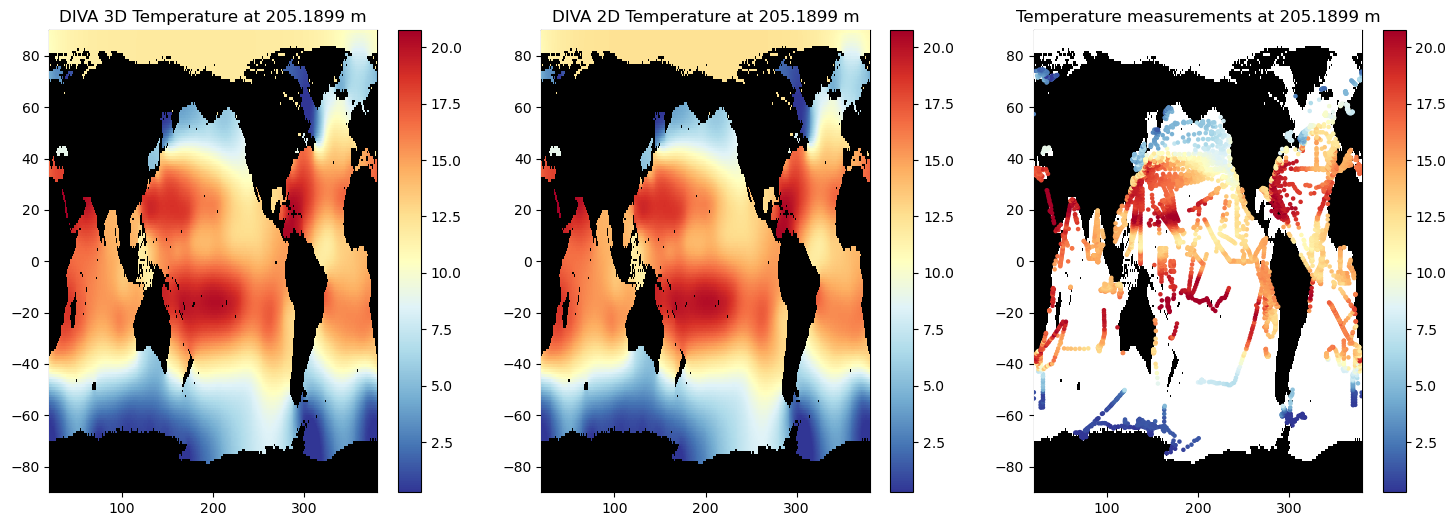

In [142]:
dindex = 25
xi, yi, mask2D = DIVAnd.load_mask(bathyfile, true, longrid, latgrid, depthgrid[dindex]);        
_, (pm, pn), (xi, yi) = DIVAnd_rectdom(longrid, latgrid);
depthsel = findall(obsdepth .== depthgrid[dindex])
@time Tinterp2, s2 = DIVAndrun(mask2D, (pm, pn), (xi, yi), (obslon[depthsel], obslat[depthsel]), 
Float64.(T[depthsel] .- mean(T[depthsel])), 
(20., 20.), epsilon2, moddim=[1,0]);

vmin = quantile(T[depthsel], 0.02)
vmax = quantile(T[depthsel], 0.98)

fig = plt.figure(figsize=(18, 6))
ax = plt.subplot(131)
pcm = plt.pcolormesh(longrid, latgrid, mean(T) .+ Tinterp[:,:,dindex]', 
cmap=plt.cm.RdYlBu_r, vmin=vmin, vmax=vmax, zorder=5)
ax.pcolormesh(longrid, latgrid, mask[:,:,dindex]', cmap=plt.cm.binary_r, zorder=3)
plt.colorbar(pcm)
ax.set_xlim(20., 380.)
ax.set_title("DIVA 3D Temperature at $(depthgrid[dindex]) m")

ax = plt.subplot(132)
pcm = ax.pcolormesh(longrid, latgrid, mean(T[depthsel]) .+ Tinterp2[:,:]', 
cmap=plt.cm.RdYlBu_r, vmin=vmin, vmax=vmax, zorder=5)
plt.colorbar(pcm)
ax.set_xlim(20., 380.)
ax.pcolormesh(longrid, latgrid, mask[:,:,dindex]', cmap=plt.cm.binary_r, zorder=3)
ax.set_title("DIVA 2D Temperature at $(depthgrid[dindex]) m")


ax = plt.subplot(133)
ax.pcolormesh(longrid, latgrid, mask[:,:,dindex]', cmap=plt.cm.binary_r, zorder=3)
pcm = ax.scatter(obslon[depthsel], obslat[depthsel], s=5, c=T[depthsel], 
cmap=plt.cm.RdYlBu_r, vmin=vmin, vmax=vmax, zorder=5);
ax.set_xlim(20., 380.)
plt.colorbar(pcm)
ax.set_title("Temperature measurements at $(depthgrid[dindex]) m")
plt.savefig(joinpath(figdir, "comparison_3D_2D_level-$(dindex).jpg"), dpi=300, bbox_inches="tight")

In [52]:
@time lenxy, infoxy = fithorzlen((obslon, obslat, obsdepth), T, depthgrid);

[ Info: Data points at z=2.5: 77643, horz. correlation length: 19.299525168361637 (preliminary)
[ Info: Data points at z=7.5: 85906, horz. correlation length: 19.097745411833095 (preliminary)
[ Info: Data points at z=12.5: 85906, horz. correlation length: 19.097745411833095 (preliminary)
[ Info: Data points at z=17.51539: 94062, horz. correlation length: 18.903903065589486 (preliminary)
[ Info: Data points at z=22.66702: 94062, horz. correlation length: 18.903903065589486 (preliminary)
[ Info: Data points at z=28.16938: 102091, horz. correlation length: 18.70182793782544 (preliminary)
[ Info: Data points at z=34.218006: 102091, horz. correlation length: 18.70182793782544 (preliminary)
[ Info: Data points at z=40.954975: 110007, horz. correlation length: 18.687258189735573 (preliminary)
[ Info: Data points at z=48.454975: 117813, horz. correlation length: 18.585626566788164 (preliminary)
[ Info: Data points at z=56.718006: 116759, horz. correlation length: 18.27673203177056 (preliminary

102.704165 seconds (2.51 G allocations: 149.513 GiB, 19.94% gc time, 0.01% compilation time)


[ Info: Data points at z=4509.18: 2951, horz. correlation length: 41.66937409798422 (preliminary)
[ Info: Smoothed horz. correlation length at z=2.5: 16.672739554524053
[ Info: Smoothed horz. correlation length at z=7.5: 16.664635767391015
[ Info: Smoothed horz. correlation length at z=12.5: 16.64845063153946
[ Info: Smoothed horz. correlation length at z=17.51539: 16.624141932799528
[ Info: Smoothed horz. correlation length at z=22.66702: 16.5908245518425
[ Info: Smoothed horz. correlation length at z=28.16938: 16.546002542606953
[ Info: Smoothed horz. correlation length at z=34.218006: 16.4858939572092
[ Info: Smoothed horz. correlation length at z=40.954975: 16.40586638980571
[ Info: Smoothed horz. correlation length at z=48.454975: 16.30102262090963
[ Info: Smoothed horz. correlation length at z=56.718006: 16.16702409887015
[ Info: Smoothed horz. correlation length at z=65.66938: 16.001073058952784
[ Info: Smoothed horz. correlation length at z=75.16702: 15.802850296677178
[ Info: 

In [84]:
lenxy, infoxy = fitvertlen((obslon, obslat, obsdepth), T, depthgrid);

LoadError: MethodError: no method matching DIVAnd.VertRandomCoupels(::Float32, ::Vector{Int64}, ::Tuple{Vector{Float32}, Vector{Float32}, Vector{Float32}}, ::Float64, ::Int64, ::Int64, ::Random._GLOBAL_RNG)

[0mClosest candidates are:
[0m  DIVAnd.VertRandomCoupels([91m::Float64[39m, ::Vector{Int64}, [91m::Tuple{Vector{Float64}, Vector{Float64}, Vector{Float64}}[39m, ::Float64, ::Int64, ::Int64, ::TRNG) where TRNG<:Random.AbstractRNG
[0m[90m   @[39m [35mDIVAnd[39m [90m~/.julia/packages/DIVAnd/EG6qD/src/[39m[90m[4mfit.jl:315[24m[39m


In [78]:
lenz, infoz = fitvertlen((Float64.(obslon), Float64.(obslat), Float64.(obsdepth)), Float64.(T), Float64.(depthgrid));

Vector{Float64} (alias for Array{Float64, 1})

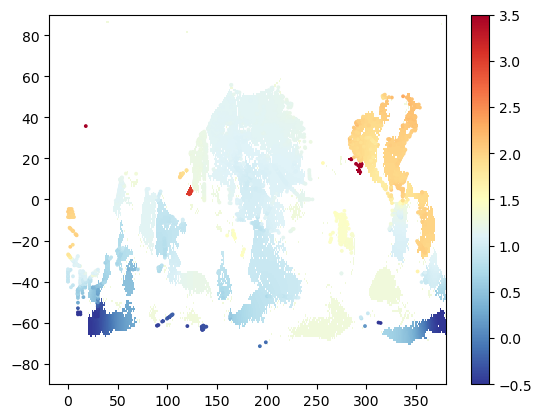

PyObject <matplotlib.colorbar.Colorbar object at 0x7f4506cda500>

In [97]:
pcm = plt.pcolormesh(longrid, latgrid, mean(T[depthsel]) .+ Tinterp2[:,:]', 
cmap=plt.cm.RdYlBu_r, vmin=-.5, vmax=3.5, zorder=5)
ax.pcolormesh(longrid, latgrid, mask[:,:,end]', cmap=plt.cm.binary_r, zorder=3)
plt.scatter(obslon[depthsel], obslat[depthsel], s=3, c=T[depthsel], vmin=-0.5, vmax=3.5, cmap=plt.cm.RdYlBu_r)
plt.colorbar(pcm)

### Loop on the depth levels

In [146]:
xi, yi, mask3D = DIVAnd.load_mask(bathyfile, true, longrid, latgrid, depthgrid);  
_, (pm, pn), (xi, yi) = DIVAnd_rectdom(longrid, latgrid);

In [148]:
for dindex in 1:length(depthgrid)
    @info("Working on depth $(depthgrid[dindex])")
    depthsel = findall(obsdepth .== depthgrid[dindex])
    @time Tinterp2D, s2D = DIVAndrun(mask3D[:,:,dindex], (pm, pn), (xi, yi), 
    (obslon[depthsel], obslat[depthsel]), Float64.(T[depthsel] .- mean(T[depthsel])), 
    (lenxy[dindex], lenxy[dindex]), epsilon2, moddim=[1,0]);
end

  0.597441 seconds (55.29 k allocations: 567.924 MiB, 66.88% gc time)
  0.604793 seconds (55.29 k allocations: 567.257 MiB, 67.63% gc time)
  0.435988 seconds (55.30 k allocations: 566.278 MiB, 55.54% gc time)
  0.582250 seconds (54.90 k allocations: 565.033 MiB, 68.21% gc time)
  0.649051 seconds (54.63 k allocations: 563.743 MiB, 67.63% gc time)
  0.596634 seconds (54.24 k allocations: 562.213 MiB, 66.47% gc time)
  0.532437 seconds (53.84 k allocations: 559.758 MiB, 53.28% gc time)
  0.615211 seconds (53.18 k allocations: 558.695 MiB, 70.32% gc time)
  0.587476 seconds (52.67 k allocations: 557.419 MiB, 67.54% gc time)
  0.414604 seconds (52.19 k allocations: 555.574 MiB, 55.56% gc time)
  0.547552 seconds (51.55 k allocations: 553.688 MiB, 67.16% gc time)
  0.571077 seconds (50.78 k allocations: 551.914 MiB, 68.87% gc time)
  0.394992 seconds (50.10 k allocations: 550.209 MiB, 54.30% gc time)
  0.569603 seconds (49.45 k allocations: 549.571 MiB, 68.82% gc time)
  0.380765 seconds (

[ Info: Working on depth 2.5
[ Info: Working on depth 7.5
[ Info: Working on depth 12.5
[ Info: Working on depth 17.51539
[ Info: Working on depth 22.66702
[ Info: Working on depth 28.16938
[ Info: Working on depth 34.218006
[ Info: Working on depth 40.954975
[ Info: Working on depth 48.454975
[ Info: Working on depth 56.718006
[ Info: Working on depth 65.66938
[ Info: Working on depth 75.16702
[ Info: Working on depth 85.01539
[ Info: Working on depth 95.0
[ Info: Working on depth 105.0
[ Info: Working on depth 115.0
[ Info: Working on depth 125.0
[ Info: Working on depth 135.0
[ Info: Working on depth 145.0
[ Info: Working on depth 155.0
[ Info: Working on depth 165.0
[ Info: Working on depth 175.0
[ Info: Working on depth 185.0
[ Info: Working on depth 195.0
[ Info: Working on depth 205.1899
[ Info: Working on depth 217.05449
[ Info: Working on depth 233.19432
[ Info: Working on depth 255.88423
[ Info: Working on depth 286.60898
[ Info: Working on depth 325.88422
[ Info: Working on 